# Teste para processo seletivo - Lopes
### Luiz Guilherme Monteiro
#### lgmonteiro7@gmail.com



# Sumário

### 1 - Análise inicial e tratamento dos dados
### 2 - Correlação entre as variáveis (básico)
### 3 - Modelo inicial de regressão logística
### 4 - Multilayer Perceptron básico
### 5 - Análise Aprofundada
### 6 - Modelo Final (Transfer Learning - Ensemble)
### 7 - Conclusões






---
---

# 1. Análise inicial e tratamento dos dados

## 1.1. Análise geral de qualidade dos dados

>Não existem indivíduos com dados faltantes e a maioria das colunas possuem tipos compatíveis com os dados.
    
>Duas características chamam a atenção:
        * alcohol que deveria ser um valor numérico apresenta tipo object;
        * quality é um valor discreto, não existe nota 5.5, por exemplo;


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.style.use('ggplot')

raw_df = pd.read_csv('./data/raw/winequality.csv', sep = ';')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   object 
 12  quality               6497 non-null   int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 660.0+ KB


## 1.1. Explorando a coluna alcohol

>É importante entender qual é o motivo que levou a coluna alcohol a ser identificada como object.
    
>Uma simples verificação do set de valores já clarifica algumas questões:

In [2]:
raw_df.alcohol.unique()

array(['8.8', '9.5', '10.1', '9.9', '9.6', '11', '12', '9.7', '10.8',
       '12.4', '11.4', '12.8', '11.3', '10.5', '9.3', '10', '10.4',
       '11.6', '12.3', '10.2', '9', '11.2', '8.6', '9.4', '9.8', '11.7',
       '10.9', '9.1', '8.9', '10.3', '12.6', '10.7', '12.7', '10.6',
       '9.2', '8.7', '11.5', '11.8', '12.1', '11.1', '8.5', '12.5',
       '11.9', '12.2', '12.9', '13.9', '14', '13.5', '13.3', '13.2',
       '13.7', '13.4', '13', '8', '13.1', '8.0', '13.6', '8.4', '14.2',
       '11.94', '128.933.333.333.333', '114.666.666.666.667', '10.98',
       '100.333.333.333.333', '114.333.333.333.333',
       '105.333.333.333.333', '953.333.333.333.333',
       '109.333.333.333.333', '113.666.666.666.667',
       '113.333.333.333.333', '110.666.666.666.667',
       '973.333.333.333.333', '11.05', '9.75', '11.35', '9.55', '10.55',
       '11.45', '14.05', '123.333.333.333.333', '12.75', '13.8', '12.15',
       '13.05', '112.666.666.666.667', '105.666.666.666.667',
       '117.333.333

>Claramente existem valores com formatação errada, tais como 923.333.333.333.333 e 113.666.666.666.667.

>Antes de tentarmos fazer um trabalho mais complexo para tentar corrigir esses valores, vamos verificar qual é a proporção dos dados com problema: 

In [3]:
error_count = sum(map(lambda x: 1 if x.count('.')>1 else 0, raw_df.alcohol.values))
print('proporção de individuos com problema na coluna alcohol: %f' % (error_count/len(raw_df)))

proporção de individuos com problema na coluna alcohol: 0.006157


>Podemos fazer duas considerações:            
>>1. Os dados com problema aparentemente estão dentro da faixa comum para os valores de alcohol se considerarmos os primeiros algarismos;
>>2. É uma suposição e, devemos levar em consideração a baixíssima proporção e possibilidade de introdução de ruído.

>Vamos removê-los a princípio, mas não será descartada a possibilidade de voltar e estudar melhor esse problema:

In [4]:
treated_df = raw_df
treated_df.alcohol = pd.to_numeric(raw_df.alcohol, errors='coerce')
treated_df.alcohol.unique()
treated_df = treated_df.dropna()
treated_df.alcohol.unique()

array([ 8.8 ,  9.5 , 10.1 ,  9.9 ,  9.6 , 11.  , 12.  ,  9.7 , 10.8 ,
       12.4 , 11.4 , 12.8 , 11.3 , 10.5 ,  9.3 , 10.  , 10.4 , 11.6 ,
       12.3 , 10.2 ,  9.  , 11.2 ,  8.6 ,  9.4 ,  9.8 , 11.7 , 10.9 ,
        9.1 ,  8.9 , 10.3 , 12.6 , 10.7 , 12.7 , 10.6 ,  9.2 ,  8.7 ,
       11.5 , 11.8 , 12.1 , 11.1 ,  8.5 , 12.5 , 11.9 , 12.2 , 12.9 ,
       13.9 , 14.  , 13.5 , 13.3 , 13.2 , 13.7 , 13.4 , 13.  ,  8.  ,
       13.1 , 13.6 ,  8.4 , 14.2 , 11.94, 10.98, 11.05,  9.75, 11.35,
        9.55, 10.55, 11.45, 14.05, 12.75, 13.8 , 12.15, 13.05, 11.75,
       10.65, 10.15, 12.25, 11.85, 11.65, 13.55, 11.95, 11.55, 12.05,
       14.9 ,  9.95,  9.25,  9.05, 10.75])

## 1.2. Explorando a coluna type

>Vale também verificar a outra variável com tipo não numérico, procurando algo fora do comum:

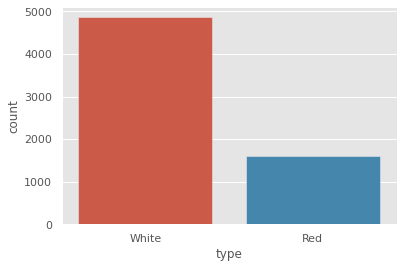

In [5]:
#Vamos ver se os tipos de vinho tem alguma sujeira
sns.countplot(x=treated_df["type"])

>Não há problemas com os tipos, apenas desbalanceamento. Existe a possibilidade de tratar esse problema mais à frente no treino do modelo, se for uma feature importante para o aprendizado.

## 1.3. Análise da qualidade dos dados nas colunas numéricas

In [6]:
raw_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6457.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268,10.489083,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806,1.192961,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000,14.900000,9.000000


>Avaliando as informações, nota-se um desvio incompatível com o desvio padrão dos quartis de algumas colunas se olharmos para os valores máximos e mínimos e seus desvios padrão, o que indica **presença de outliers**.

>Um boxplot ou violinplot com os dados normalizados podem ajudar a visualizar melhor esse problema:
 

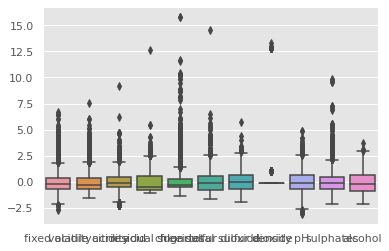

In [7]:
from sklearn.preprocessing import StandardScaler
cols_to_norm = [x for x in treated_df.columns if x not in ['type','quality']]
norm_df = treated_df.iloc[:,1:12]
norm_df[cols_to_norm] = StandardScaler().fit_transform(treated_df[cols_to_norm])
sns.boxplot(data=norm_df)


>Vemos claramente a presença de valores muito destoantes dos valores médios encontrados em cada coluna
>Temos algumas formas de remover esses pontos, por exemplo:
* Inter Quartile Range (IQR)
* Z-value
* Tukey Fences

>Para essa análise, será usado o método do z-value, pois assim tenho mais controle sobre a remoção dos outliers. Temos que levar em consideração que nosso dataset não é muito grande e que podemos lidar com outliers não muito destoantes da média de outras formas, como será visto mais a frente.

>Temos para o z-value a seguinte equação:
$$
z= \frac{x - \mu}{\sigma}
$$
Onde: 
* x é o ponto
* $\mu$ é a média
* $\sigma$ é o desvio padrão

>Dessa forma posso controlar o valor do z-score para que seja mais ou menos agressivo
	
 

In [8]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(norm_df))
norm_df_clean = norm_df[(z < 2.150).all(axis=1)]

>Vemos um resultado mais equilibrado, mas não a ponto de reduzir drasticamente nossos dados

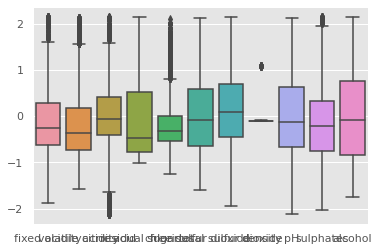

In [9]:
sns.boxplot(data=norm_df_clean)

>Ajustando os dados categóricos e preparando o dataset para as análises:

In [10]:
final_df = norm_df_clean.copy()
final_df['type'] = raw_df.iloc[:,0]
final_df['quality'] = raw_df.iloc[:,-1]
final_df = final_df.replace("White", -1)
final_df = final_df.replace("Red", 1)
final_df = final_df[raw_df.columns]

## 2. Correlações entre as variáveis (básico)
>Primeiramente vamos analisar as correlações utilizando-se o **coeficiente de correlação de Pearson** e o **coeficiente de correlação tau de Kendall**.

>Sendo o coeficiente de correlação de Pearson descrito por:

$$
\rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}
$$

>Onde a estimativa tem como base em r:

$$
r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}
$$

>Assim, temos:

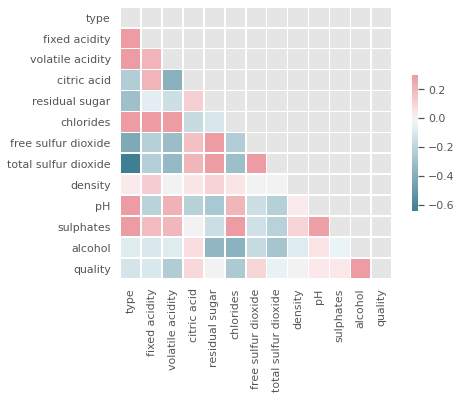

In [11]:
import numpy as np
def corr_matrix_plot(method):
    corr = final_df.corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    f, ax = plt.subplots(figsize=(7, 5))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    figure = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return figure

corr_matrix_plot('pearson')

>Podemos ver pela matriz que os dados em sua completude tendem a dar maior importância para o alcool, sendo alcool e qualidade positivamente correlacionadas.

> A acidez volátil e os cloretos tem correlação negativa com a qualidade do vinho.



>Sendo tau de Kendall:

$$
\tau = \frac{c-d}{c+d} = \frac{S}{
	\left(
	\begin{matrix} 
 	n \\
 	2
\end{matrix}
\right)}
= \frac{2S}{n(n-1)}
$$


>**O mesmo comportamento é esperado para tau de Kendall, porém com resultados de correlação positiva um pouco mais relaxados, uma vez que a variável de interesse apresenta distribuição muito próxima à normal**.


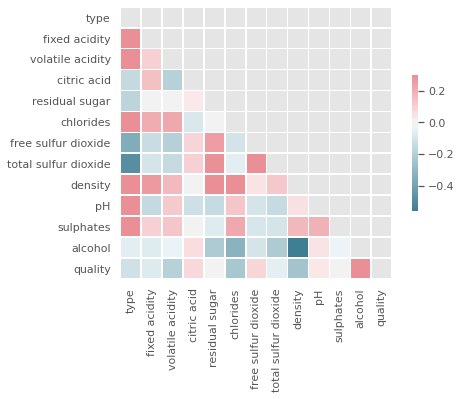

In [12]:
corr_matrix_plot('kendall')

## 3. Modelo inicial de regressão logística

>O treinamento será realizado utilizando XGBoost e a otimização dos hiperparâmetros será feita por otimização Bayesiana.

>A otimização Bayesiana é um método de otimização ótimo para encontrarmos máximos em funções com menos iterações que outros métodos, ainda mantendo certo nível de explicabilidade. A decisão de usar esse método foi feita de modo a manter essa análise com custo computacional não muito alto, mas ainda prática. 

>A otimização bayesiana baseia-se em dois pontos importantes:
* Função de aquisição, na forma:


$$
aLCB(x ; {xn, yn}, θ) = µ(x ; {xn, yn}, θ) − κ σ(x ; {xn, yn}, θ)
$$
> sendo k uma constante de balancemento da exploração global e local.

>* Função de covariância, definida por:

$$
r
2
(x, x
'
) = X
D
d=1
(xd − x
'
d
)
2
/θ^2
d
$$

> Assim podemos treinar um modelo com os dados e analisarmos algumas métricas para vermos o resultado básico do aprendizado:

In [13]:
from yellowbrick.classifier import ConfusionMatrix
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy
from bayes_opt import BayesianOptimization
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


X = final_df.iloc[:,0:12]
Y = final_df.iloc[:,12]
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=28)

X_test_ensemble = X
y_test_ensemble = Y

def generic_model(gamma, learning_rate,max_depth,min_child_weight,
           reg_alpha,reg_lambda,subsample):
    model = XGBClassifier(gamma=gamma,                 
                     learning_rate=learning_rate,
                     max_depth=int(max_depth),
                     min_child_weight=min_child_weight,
                     n_estimators=1000,                                                                    
                     reg_alpha=reg_alpha,
                     reg_lambda=reg_lambda,
                     subsample=subsample,
                     seed=28,
                     nthread = 8,
                     eval_metric = 'auc')

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovo')

# Bounded region of parameter space
pbounds = {'gamma':(0,4),                 
                 'learning_rate':(0.01,0.06),
                 'max_depth': (3,7),
                 'min_child_weight':(0,3),
                 'reg_alpha':(0,3),
                 'reg_lambda':(0,3),
                 'subsample':(0.5,0.9),}

optimizer = BayesianOptimization(
    f=generic_model,
    pbounds=pbounds,
    random_state=1,
)

def bay_optimizer(optimizer):
    optimizer.maximize(
    init_points=5,
    n_iter=20,
)
#bay_optimizer(optimizer)

model = XGBClassifier(objective = 'reg:logistic',
                gamma=0.2911,                 
                learning_rate=0.0302,
                max_depth=7,
                min_child_weight = 0.02947,
                reg_alpha = 1.951,
                reg_lambda=2.793,
                n_estimators=1000,                                                                    
                subsample=0.9,
                seed=28,
                nthread = 8,
                eval_metric = 'auc')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2, output_dict=False))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("\n OBS: os hiperparâmetros do modelo já foram otimizados, se quiser ver o otimizador funcionando, descomente a linha 57")

/home/luiz/Documentos/processos/proc-lopes/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.60      0.20      0.31        44
           5       0.67      0.68      0.67       441
           6       0.65      0.74      0.69       672
           7       0.60      0.53      0.56       245
           8       0.85      0.40      0.54        58
           9       0.00      0.00      0.00         3

    accuracy                           0.65      1467
   macro avg       0.48      0.36      0.40      1467
weighted avg       0.65      0.65      0.64      1467

Accuracy: 65.24%

 OBS: os hiperparâmetros do modelo já foram otimizados, se quiser ver o otimizador funcionando, descomente a linha 57


/home/luiz/Documentos/processos/proc-lopes/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> Temos um resultado básico sobre um modelo sem feature engineering e sem maiores análises. Vamos tentar ganhar mais performance.

# 4. Multilayer Perceptron básico

>Vamos, por curiosidade, analisar como uma rede MLP se sai com os dados sem feature engineering para compararmos com a regressão logística. 

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras import backend as K

X = final_df.iloc[:,0:12]
Y = final_df.iloc[:,12]


def mlp():
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

estimator = KerasClassifier(build_fn=mlp, epochs=6, batch_size=5, verbose=0)
kfold = KFold(n_splits=6, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.max()*100))

Using TensorFlow backend.


Accuracy: 57.91%


# 5. Análise aprofundada

## 5.1. Verificação da existência de centróides bem definidos na amostra

>Sabemos que existem diferentes tipos de vinho até agora: Tinto e Branco. Além destes, existam talvez grupos que não estão tão explícitos e que possam nos interessar.

>Iniciaremos a verificação detectando possíveis formações ótimas de grupos (elbow method):

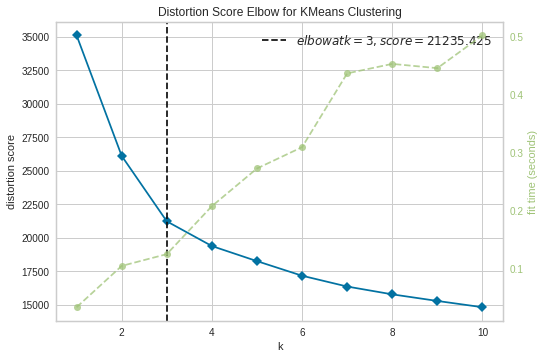

/home/luiz/Documentos/processos/proc-lopes/venv/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fb950101490>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [15]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

X = final_df.iloc[:,0:12]

kelbow_visualizer(KMeans(init ='k-means++', random_state=4), X, k=(1,11))

> Obtemos que o melhor número de grupos possível é 3, mas ainda não sabemos qual é aqualidade dessa distinção.

>Vamos criar um modelo e avaliarmos os PCAs:

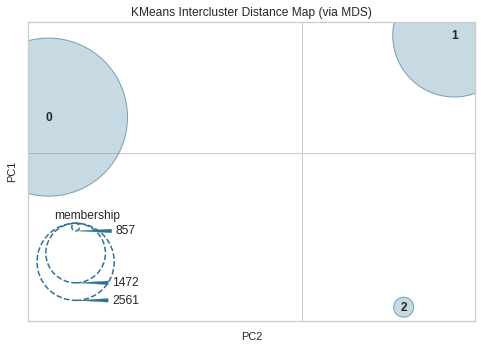

/home/luiz/Documentos/processos/proc-lopes/venv/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fba6f7880d0>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=None,
                     scoring='membership')

In [16]:
from yellowbrick.cluster import intercluster_distance
kmeans = KMeans(n_clusters=3, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_kmeans = kmeans.fit_predict(X)
intercluster_distance(kmeans, X)

> Temos três componentes claramente definidos.

## 5.2. Distribuição de notas entre os grupos

> Vamos visualizar a distribuição de notas menos comuns em cada um desses grupos levando o tamanho de cada um em consideração.

> Vamos responder a seguinte pergunta: Se eu tirar um indivíduo qualquer desse grupo, qual é a probabilidade de ser de nota X? (Considerando apenas as notas 3,4,7,8,9)

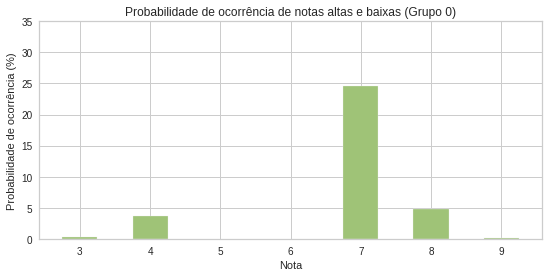

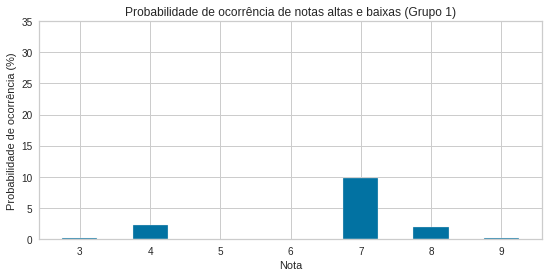

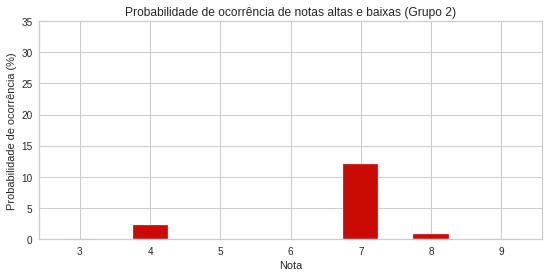

In [17]:
final_df['kmeans_group'] = y_kmeans
total_group_count = final_df.kmeans_group.value_counts()
group0_df = final_df[final_df['kmeans_group']==0]
group0_counts = group0_df.quality.value_counts()
group0_maping = dict()
for i in range(3,10):
    if i not in (5,6):
        group0_maping[i] = 0
    
for item in group0_counts.keys():
    if item not in (5,6):
        group0_maping[item] = group0_counts[item]/total_group_count[0]*100
group0_maping = dict(sorted(group0_maping.items()))

fig = plt.figure(figsize=(9,4))

plt.bar(group0_maping.keys(), group0_maping.values(), width=.5, color='g')
plt.xlabel("Nota")
plt.ylabel("Probabilidade de ocorrência (%)")
plt.title("Probabilidade de ocorrência de notas altas e baixas (Grupo 0)")
plt.ylim(0, 35)
plt.show()

group1_df = final_df[final_df['kmeans_group']==1]
group1_counts = group1_df.quality.value_counts()
group1_maping = dict()
for i in range(3,10):
    if i not in (5,6):
        group0_maping[i] = 0
    
for item in group1_counts.keys():
    if item not in (5,6):
        group1_maping[item] = group1_counts[item]/total_group_count[1]*100
group1_maping = dict(sorted(group1_maping.items()))

plt.figure(figsize=(9,4))
plt.bar(group1_maping.keys(), group1_maping.values(), width=.5, color='b')
plt.xlabel("Nota")
plt.ylabel("Probabilidade de ocorrência (%)")
plt.title("Probabilidade de ocorrência de notas altas e baixas (Grupo 1)")
plt.ylim(0, 35)
plt.show()

group2_df = final_df[final_df['kmeans_group']==2]
group2_counts = group2_df.quality.value_counts()
group2_maping = dict()
for i in range(3,10):
    if i not in (5,6):
        group2_maping[i] = 0
    
for item in group2_counts.keys():
    if item not in (5,6):
        group2_maping[item] = group2_counts[item]/total_group_count[2]*100
group2_maping = dict(sorted(group2_maping.items()))

plt.figure(figsize=(9,4))
plt.bar(group2_maping.keys(), group2_maping.values(), width=.5, color='r')
plt.xlabel("Nota")
plt.ylabel("Probabilidade de ocorrência (%)")
plt.title("Probabilidade de ocorrência de notas altas e baixas (Grupo 2)")
plt.ylim(0, 35)
plt.show()

>Os grupos mostram diferentes erros padrão, podemos nos aproveitar desse fato para tirarmos um pouco mais de performance na nossa modelagem.

## 5.3. Covariância em cada grupo

>Vamos verificar as relações de cada grupo utilizando a ***explanação aditiva de Shapley*** com a nossa variável de interesse, treinando um modelo distinto para cada grupo:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


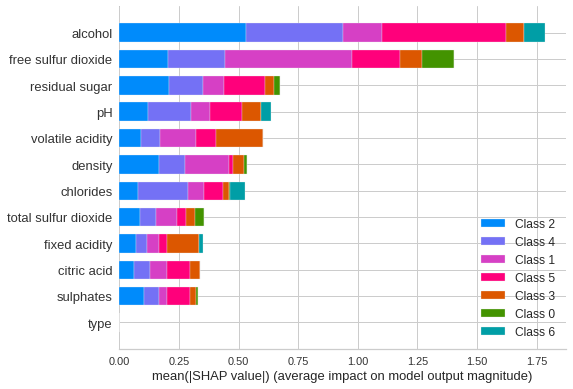

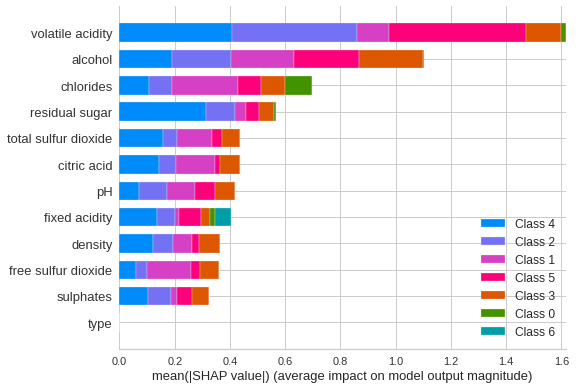

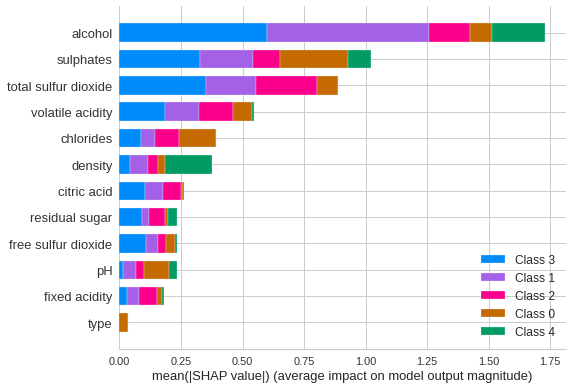

In [18]:
from yellowbrick.classifier import ConfusionMatrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import scipy
import shap

test_size = 0.1
random_state=28

X = group0_df.iloc[:, 0:12]
Y = group0_df.iloc[:, 12]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=28)
def train_model(X_train, y_train):
    model = XGBClassifier(objective = 'reg:logistic',
                            gamma=0.5,                 
                            learning_rate=0.05207,
                            max_depth=4,
                            min_child_weight=1.2,
                            n_estimators=100,                                                                    
                            reg_alpha=1,
                            reg_lambda=0.7 ,                                                                   
                            subsample=0.8,
                            seed=28,
                            nthread = 8,
                            eval_metric = 'auc')
    model.fit(X_train, y_train)
    return model

model_kmeans_0 = train_model(X_train, y_train)
explainer = shap.TreeExplainer(model_kmeans_0)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


X = group1_df.iloc[:, 0:12]
Y = group1_df.iloc[:, 12]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
model_kmeans_1= train_model(X_train, y_train)
explainer = shap.TreeExplainer(model_kmeans_1)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

X = group2_df.iloc[:, 0:12]
Y = group2_df.iloc[:, 12]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
model_kmeans_2 = train_model(X_train, y_train)
explainer = shap.TreeExplainer(model_kmeans_2)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

> Cada um dos grupos mostra diferentes principais atributos para a nota final. O modelo único só considera o mais importante para a maioria, que como vimos, é o alcool. Mas repare como as importâncias são diferentes para diferentes grupos! 

>Podemos usar isso a nosso favor.

# 6. Modelo Final (Transfer Learning - Ensemble)

> Com os modelos treinados para cada grupo, podemos criar um ensemble com o seguinte pipeline:

                          .--> Modelo grupo 1 ---->-----.
                          |                             |
----> DADOS -> modelo K-MEANS -------> Modelo grupo 2    ------------>---------|----------> Output

                          |                             |
                          '--> Modelo grupo 3----->-----'

In [19]:
X = final_df.iloc[:,0:12]
Y = final_df.iloc[:,12]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=28)

X_test_ensemble = X
X_test_ensemble['quality'] = list(Y)
X_test_ensemble['kmeans_group'] = kmeans.fit_predict(X_test_ensemble.iloc[:,0:12])
X_test_ensemble = X_test_ensemble.sort_values(['kmeans_group'], ascending=[1])


X_test_ensemble_0 = X_test_ensemble[X_test_ensemble['kmeans_group']==0].iloc[:,0:12]
y_test_ensemble_0 = X_test_ensemble[X_test_ensemble['kmeans_group']==0].iloc[:,12].values

X_test_ensemble_1 = X_test_ensemble[X_test_ensemble['kmeans_group']==1].iloc[:,0:12]
y_test_ensemble_1 = X_test_ensemble[X_test_ensemble['kmeans_group']==1].iloc[:,12].values

X_test_ensemble_2 = X_test_ensemble[X_test_ensemble['kmeans_group']==2].iloc[:,0:12]
y_test_ensemble_2 = X_test_ensemble[X_test_ensemble['kmeans_group']==2].iloc[:,12].values


predictions_group_0 = model_kmeans_0.predict(X_test_ensemble_0)
predictions_group_1 = model_kmeans_1.predict(X_test_ensemble_1)
predictions_group_2 = model_kmeans_2.predict(X_test_ensemble_2)

final_predictions = []
final_true_y = []
final_predictions = list(predictions_group_0) + list(predictions_group_1) + list(predictions_group_2) 
final_true_y = list(y_test_ensemble_0) + list(y_test_ensemble_1) + list(y_test_ensemble_2)


print(classification_report(final_true_y, final_predictions, digits=2, output_dict=False))
print("Accuracy: %.2f%%" % (accuracy_score(final_true_y, final_predictions)*100))



              precision    recall  f1-score   support

           3       0.00      0.00      0.00        10
           4       0.95      0.39      0.56       147
           5       0.80      0.78      0.79      1522
           6       0.70      0.87      0.78      2171
           7       0.81      0.56      0.66       878
           8       0.96      0.29      0.45       157
           9       0.00      0.00      0.00         5

    accuracy                           0.75      4890
   macro avg       0.60      0.41      0.46      4890
weighted avg       0.77      0.75      0.74      4890

Accuracy: 75.13%


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# 7. Conclusões

>Conseguimos melhorar nossa performance com algumas análises mais aprofundadas. Temos indícios de over/underfitting em algumas classes, mas um pouco mais de exploração ajudaria a resolvermos este e outros pequenos problemas.

> Ainda daria pra fazer muita coisa. Feature engineering, como já citado, é uma delas. Como essa análise é um teste inicial, não vou me aprofundar mais, mas qualquer dúvida sinta-se livre pra me contatar :)